# Train Keras OCR with Ionograms

In the last Notebook, I tried to train Keras OCR with synthetic data, but the results weren't conclusive. The goal here is to train Keras OCR with the text that is already on the ionograms. Here are the refences :
https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html
https://stackoverflow.com/questions/52004133/how-to-improve-image-quality
https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv

In [16]:
data_dir = 'L:/DATA/ISIS/keras_ocr/'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import datetime

import keras_ocr

## Train the recognizer
After some research, training the detector seems hard and time consuming, so we'll start by training the recognizer with our own pictures. To train the recognizer, we need small images of digits from ionograms. I cropped 60 ionograms and their metadata. After doing some tests, I came to realize that the detector was working better when the images are only black and white, so I did a little bit of pre-processing (see the Notebook *Pre-process training images*). Here how it looks like.

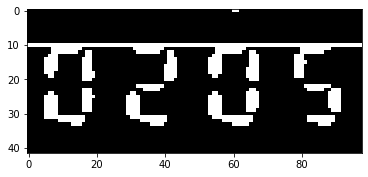

In [18]:
im = plt.imread(data_dir+'test_images/contrast/20-5.png')
plt.imshow(im)

I also created a txt file with the name of the images and the right numbers. It looks like this.

In [3]:
import pandas as pd

dataset = pd.read_csv(data_dir+'test_images/contrast/annotations.txt', header=None, 
                      names=['file','text'], dtype={'file' : str, 'text' : str})
dataset['file'] = data_dir+'test_images/contrast/' + dataset['file']
dataset['text'] = dataset['text'].astype(str)
dataset.insert(1, 'empty', None)

dataset.head(6)

,file,empty,text
0,L:/DATA/ISIS/keras_ocr/test_images/contrast/1-...,None,36
1,L:/DATA/ISIS/keras_ocr/test_images/contrast/1-...,None,00
2,L:/DATA/ISIS/keras_ocr/test_images/contrast/1-...,None,69
3,L:/DATA/ISIS/keras_ocr/test_images/contrast/1-...,None,11
4,L:/DATA/ISIS/keras_ocr/test_images/contrast/1-...,None,0354
5,L:/DATA/ISIS/keras_ocr/test_images/contrast/1-...,None,35


We now divide the images for training and testing.

In [4]:
train_subset, test_subset = sklearn.model_selection.train_test_split(dataset, test_size=0.2)

train_subset.reset_index(inplace=True, drop=True)
test_subset.reset_index(inplace=True, drop=True)

train = []
for i in range(len(train_subset)):
    train.append(tuple(train_subset.loc[i].to_list()))

test = []
for i in range(len(test_subset)):
    test.append(tuple(test_subset.loc[i].to_list()))

We specify that our alphabet is only numbers.

In [5]:
import string
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan_notop.h5


We divide the training images in training and validation.

In [6]:
batch_size = 1
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train, augmenter), (test, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

252 / 252 instances have illegal characters.
text: 0354


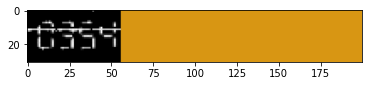

In [7]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

Time for the training to begin!

In [8]:
recognizer_basepath = os.path.join('L:/DATA/ISIS/keras_ocr/', f'recognizer_{datetime.datetime.now().isoformat()}')
callbacks=[
    tf.keras.callbacks.EarlyStopping(restore_best_weights=False, patience=10),
    tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')        
    ]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
    workers=0,
    batch_size=batch_size
)

Epoch 1/1000
252/252 [==============================] - 38s 102ms/step - loss: 7.3315 - val_loss: 7.2346
Epoch 2/1000
252/252 [==============================] - 21s 85ms/step - loss: 6.2646 - val_loss: 6.1809
Epoch 3/1000
252/252 [==============================] - 23s 92ms/step - loss: 5.4370 - val_loss: 6.1032
Epoch 4/1000
252/252 [==============================] - 22s 89ms/step - loss: 4.8658 - val_loss: 4.6592
Epoch 5/1000
252/252 [==============================] - 22s 87ms/step - loss: 4.0655 - val_loss: 4.7451
Epoch 6/1000
252/252 [==============================] - 24s 95ms/step - loss: 3.3568 - val_loss: 4.1650
Epoch 7/1000
252/252 [==============================] - 24s 95ms/step - loss: 3.0081 - val_loss: 6.1425
Epoch 8/1000
252/252 [==============================] - 25s 99ms/step - loss: 2.4006 - val_loss: 3.0249
Epoch 9/1000
252/252 [==============================] - 21s 85ms/step - loss: 2.0011 - val_loss: 2.8361
Epoch 10/1000
252/252 [==============================] - 22s 88

Test a couple of images with our improved recognizer

1/1 [==============================] - 0s 77ms/step
Predicted: 19, Actual:  19


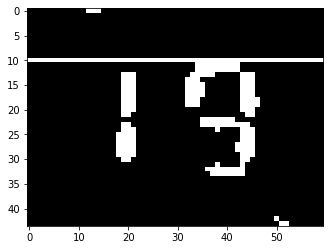

In [19]:
image_filepath, _, actual = test[0]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

1/1 [==============================] - 0s 85ms/step
Predicted: 56, Actual:  58


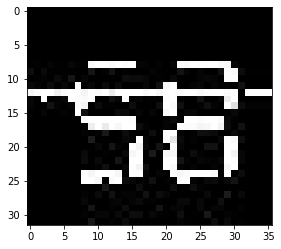

In [20]:
image_filepath, _, actual = test[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

1/1 [==============================] - 0s 104ms/step
Predicted: 16, Actual:  16


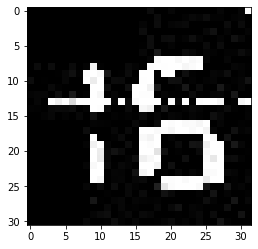

In [21]:
image_filepath, _, actual = test[2]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

Let's test it on real ionograms picked at random.

In [99]:
from random import randrange
def draw_random_subdir(dataDir):
    directory_list = os.listdir(dataDir)
    directory = directory_list[randrange(len(directory_list))]
    subdirectory_list = os.listdir(dataDir + directory + '/')
    subdirectory = subdirectory_list[randrange(len(subdirectory_list))]
    image_list = os.listdir(dataDir + directory + '/'+subdirectory+'/')
    image = image_list[randrange(len(image_list))]    
    return directory, subdirectory, image

dataDir = 'L:/DATA/ISIS/raw_upload_20230421/'
img_list=[]
img_path=[]
for i in range(3):
    directory, subdirectory, image = draw_random_subdir(dataDir)
    img_list.append(image)
    img_path.append(dataDir + directory + '/' + subdirectory + '/' + image)

In [100]:
img_path

['L:/DATA/ISIS/raw_upload_20230421/R014207767/B1-35-26 ISIS B D-810/Image0047.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207872/B1-35-15 ISIS B D-134/Image0234.png',
 'L:/DATA/ISIS/raw_upload_20230421/R014207848/B1-35-7 ISIS A C-1520/Image0235.png']

We need to apply the same filter I did on the cropped images used to train keras ocr.

In [101]:
from PIL import Image
import cv2

saveDir = 'L:/DATA/ISIS/keras_ocr/test_images/testing/'

# Change contrast and brightness
for i,img in enumerate(img_path) :
    im = cv2.imread(img)
    alpha=1.8
    beta=-50
    im = alpha*im + beta
    cv2.imwrite(saveDir+img_list[i],im)

new_img = []
# Change the colors
black = (0,0,0)
white = (255,255,255)
threshold = (85,85,85)

for img in img_list :
    # Open input image in grayscale mode and get its pixels.
    image = Image.open(saveDir+img).convert("LA")
    pixels = image.getdata()
    newPixels = []

    # Compare each pixel 
    for pixel in pixels:
        if pixel < threshold:
            newPixels.append(black)
        else:
            newPixels.append(white)

    # Create and save new image.
    image = Image.new("RGB",image.size)
    image.putdata(newPixels)
    new_img.append(np.array(image))

Pass the images to the recognizer.

Looking for C:\Users\mfortier\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 0s 362ms/step


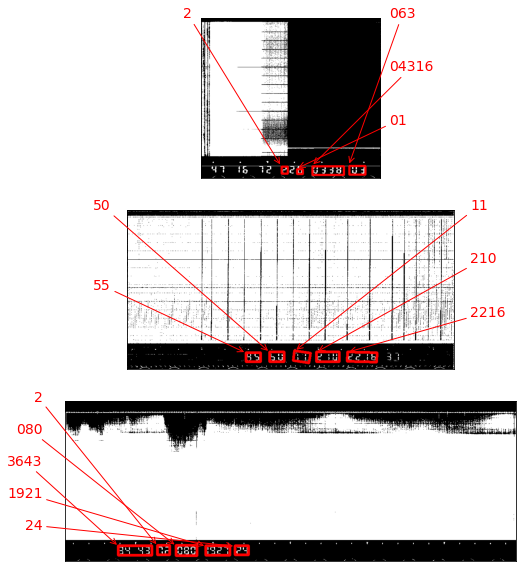

In [102]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)
prediction_groups = pipeline.recognize(new_img)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(new_img), figsize=(15, 10))
for ax, image, predictions in zip(axs, new_img, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

Let's see the results if the images are cropped.

1/1 [==============================] - 0s 48ms/step


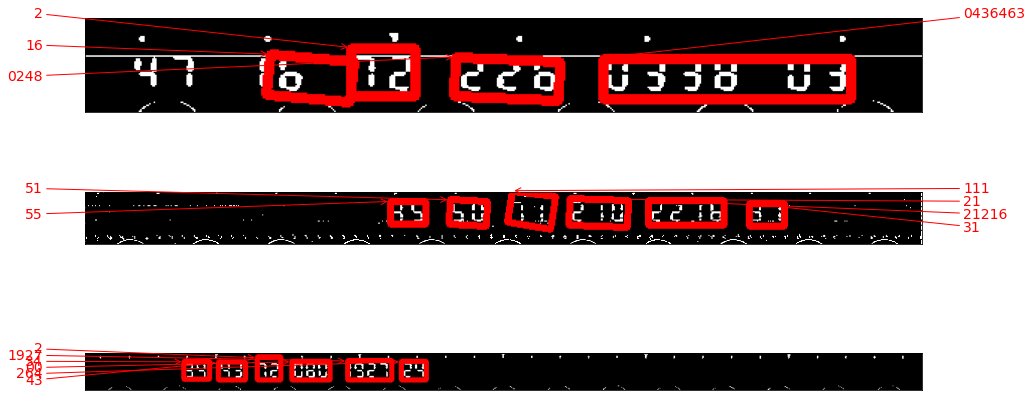

In [105]:
crop_img=[]
for i,im in enumerate(new_img) :
    height, width, _ = im.shape
    im = im[int(height-height*0.125):height,0:width]
    crop_img.append(im)
prediction_groups = pipeline.recognize(crop_img)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(crop_img), figsize=(15, 8))
for ax, image, predictions in zip(axs, crop_img, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

In [104]:
prediction_groups

[[('2',
   array([[178.,  20.],
          [221.,  20.],
          [221.,  52.],
          [178.,  52.]], dtype=float32)),
  ('16',
   array([[124.17038 ,  24.515974],
          [180.33301 ,  29.78122 ],
          [177.79187 ,  56.886734],
          [121.62924 ,  51.62149 ]], dtype=float32)),
  ('0248',
   array([[248.25555 ,  26.355984],
          [318.80505 ,  29.069424],
          [317.79028 ,  55.453472],
          [247.24078 ,  52.740032]], dtype=float32)),
  ('0436463',
   array([[347.,  27.],
          [513.,  27.],
          [513.,  54.],
          [347.,  54.]], dtype=float32))],
 [('111',
   array([[424.60632  ,  -1.7090521],
          [467.63812  ,   4.745716 ],
          [462.9364   ,  36.09046  ],
          [419.9046   ,  29.635693 ]], dtype=float32)),
  ('21',
   array([[481.1405  ,   6.661592],
          [539.5474  ,   8.198616],
          [538.85815 ,  34.391003],
          [480.45123 ,  32.853977]], dtype=float32)),
  ('51',
   array([[362.26923 ,   7.346155],
         

Save the trained recognizer.

In [98]:
recognizer.model.save_weights(data_dir +'ISIS_reading_contrast.h5')